In [10]:
import h5py
import pandas as pd
import loss_function
import os

if True:
    onebody = {}
    twobody = {}
    onebody_keys = []
    twobody_keys = []
    ai_descriptors = "../h4_data/ai_descriptors.csv"
    minimum_1s_occupation = 3.7
    onebody_params = ['E0','t']
    twobody_params = ['U']
    w_0 = 0.5
    lamb = 0.1
    with h5py.File("../h4_data/named_terms_new.hdf5", "r") as f:
        for k in f["onebody"].keys():
            onebody[k] = f[f"onebody/{k}"][()]
            onebody_keys.append(k)
        for k in f["twobody"].keys():
            twobody[k] = f[f"twobody/{k}"][:]
            twobody_keys.append(k)
    ai_df = pd.read_csv(ai_descriptors)
    ai_df = ai_df[ai_df.E0 > minimum_1s_occupation]
    ai_df = ai_df[ai_df.U < 1.3]  # Need to remove the top two states from the optimization

    matches = onebody_params + twobody_params

    w_1 = 1 - w_0

    weights = [w_0, w_1, lamb]  # w_0, w_1, lamb


In [23]:
import numpy as np
from loss_function import descriptor_distance, unmapped_penalty
import solver
from scipy.optimize import linear_sum_assignment

def evaluate_loss(
    params: np.ndarray,
    keys,
    onebody,
    twobody,
    ai_df,
    nroots,
    matches,
    norm,
    max_ai_energy= None,
) -> float:
   
    if max_ai_energy is None:
        max_ai_energy = np.max(ai_df["energy"])

    params = pd.Series(params, index=keys)

    descriptors, fcivec = solver.solve_effective_hamiltonian(
        onebody, twobody, params, nroots=nroots, ci0=None
    )

    dist_des = descriptor_distance(
        ai_df, descriptors, matches=matches, norm=norm
    )
    dist_energy = descriptor_distance(
        ai_df, descriptors, matches=["energy"], norm=norm
    )
    distance = dist_energy + dist_des
    row_ind, col_ind = linear_sum_assignment(distance)

    sloss =  dist_energy
    dloss = dist_des
    not_col_ind = np.delete(np.arange(nroots), col_ind)

    penalty = np.maximum(0,max_ai_energy-descriptors['energy'][not_col_ind])
    #unmapped_penalty(
    #    descriptors["energy"], max_ai_energy, norm=norm
    #)
    return {'sloss':sloss, 'dloss':dloss, 'penalty':penalty}




Text(0.5, 1.0, 'Descriptor loss')

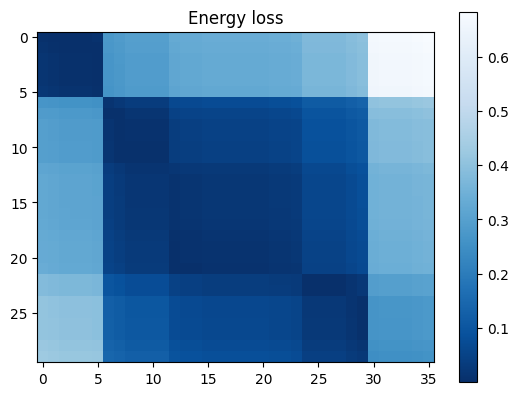

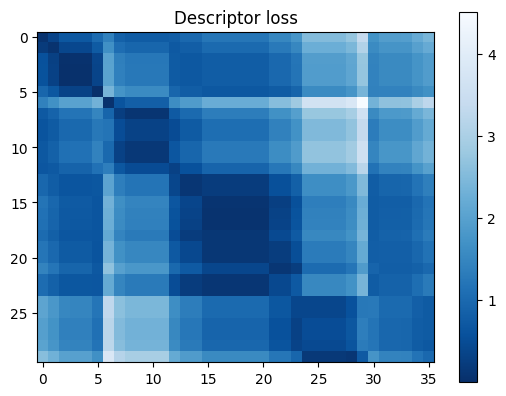

In [39]:
import matplotlib.pyplot as plt
d = evaluate_loss(params = [-.02, .33, -.5], 
              keys = ['t','U','E0'],  
              onebody = onebody, 
              twobody = twobody, 
              ai_df = ai_df, 
              nroots = 36, 
              matches = ['t','U'], 
              norm = {'t':1, 'U':1, 'energy':1, 'E0':1})

energy_loss = d['sloss']
descriptor_loss = d['dloss']
plt.figure()
cmap = plt.imshow(np.sqrt(d['sloss']), cmap = 'Blues_r')
plt.colorbar(cmap)
plt.title("Energy loss")

plt.figure()
cmap = plt.imshow(np.sqrt(d['dloss']), cmap = 'Blues_r')
plt.colorbar(cmap)
plt.title("Descriptor loss")